In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [26]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, dropout_rate=0.1, use_dropout=True):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        ]
        if use_dropout:
            layers.append(nn.Dropout2d(dropout_rate))
        
        layers.extend([
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        ])
        if use_dropout:
            layers.append(nn.Dropout2d(dropout_rate))
        
        self.double_conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.double_conv(x)

In [27]:
class SE(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SE, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        
        # Squeeze-and-Excitation layers
        self.fc1 = nn.Linear(channels, channels // reduction, bias=False)
        self.fc2 = nn.Linear(channels // reduction, channels, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        b, c, h, w = x.size()
        
        # Squeeze: Global average pooling [B, C, H, W] -> [B, C, 1, 1]
        y = self.avg_pool(x).view(b, c)  # [B, C]
        
        # Excitation: FC -> ReLU -> FC -> Sigmoid
        y = self.fc1(y)  # [B, C//reduction]
        y = self.relu(y)
        y = self.fc2(y)  # [B, C]
        attention = self.sigmoid(y).view(b, c, 1, 1)  # [B, C, 1, 1]
        
        # Apply attention
        output = x * attention
        
        return output

In [28]:
class FeatureFusion(nn.Module):
    def __init__(self, channels, dropout_rate=0.1, use_dropout=True):
        super().__init__()
        layers = [
            nn.Conv2d(channels * 2, channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
        ]
        if use_dropout:
            layers.append(nn.Dropout2d(dropout_rate))
        self.fusion_conv = nn.Sequential(*layers)
        
        # Add SE attention
        self.se = SE(channels)

    def forward(self, f1, f2):
        fused = torch.cat([f1, f2], dim=1)
        fused = self.fusion_conv(fused)
        # Apply SE attention
        fused = self.se(fused)
        return fused

In [29]:
class SiameseEncoder(nn.Module):
    def __init__(self, in_channels=3, features=[64,128,256,512], dropout_rate=0.1):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, features[0], dropout_rate, use_dropout=False)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(features[0], features[1], dropout_rate, use_dropout=False)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(features[1], features[2], dropout_rate, use_dropout=False)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = DoubleConv(features[2], features[3], dropout_rate = 0.15, use_dropout=False)
        self.pool4 = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(features[3], features[3] * 2, dropout_rate = 0.2, use_dropout=True)

    def forward(self, x):
        e1 = self.enc1(x); p1 = self.pool1(e1)
        e2 = self.enc2(p1); p2 = self.pool2(e2)
        e3 = self.enc3(p2); p3 = self.pool3(e3)
        e4 = self.enc4(p3); p4 = self.pool4(e4)
        bottleneck = self.bottleneck(p4)
        return [e1, e2, e3, e4, bottleneck]

In [30]:
class SiameseUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[32,64,128,256], dropout_rate=0.15):
        super().__init__()
        self.encoder = SiameseEncoder(in_channels, features, dropout_rate)
        self.fusion1 = FeatureFusion(features[0], dropout_rate, use_dropout=False)
        self.fusion2 = FeatureFusion(features[1], dropout_rate, use_dropout=False)
        self.fusion3 = FeatureFusion(features[2], dropout_rate, use_dropout=False)
        self.fusion4 = FeatureFusion(features[3], dropout_rate=0.1, use_dropout=True)
        self.fusion_bottleneck = FeatureFusion(features[3] * 2, dropout_rate=0.5, use_dropout=True)

        self.up4 = nn.ConvTranspose2d(features[3] * 2, features[3], kernel_size=2, stride=2)
        self.dec4 = DoubleConv(features[3] * 2, features[3], dropout_rate, use_dropout=True)

        self.up3 = nn.ConvTranspose2d(features[3], features[2], kernel_size=2, stride=2)
        self.dec3 = DoubleConv(features[2] * 2, features[2], dropout_rate, use_dropout=True)

        self.up2 = nn.ConvTranspose2d(features[2], features[1], kernel_size=2, stride=2)
        self.dec2 = DoubleConv(features[1] * 2, features[1], dropout_rate, use_dropout=True)

        self.up1 = nn.ConvTranspose2d(features[1], features[0], kernel_size=2, stride=2)
        self.dec1 = DoubleConv(features[0] * 2, features[0], dropout_rate, use_dropout=True)

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        pre_img = x[:, :3, :, :]
        post_img = x[:, 3:, :, :]
        pre_features = self.encoder(pre_img)
        post_features = self.encoder(post_img)
        fused_e1 = self.fusion1(pre_features[0], post_features[0])
        fused_e2 = self.fusion2(pre_features[1], post_features[1])
        fused_e3 = self.fusion3(pre_features[2], post_features[2])
        fused_e4 = self.fusion4(pre_features[3], post_features[3])
        fused_bottleneck = self.fusion_bottleneck(pre_features[4], post_features[4])

        d4 = self.up4(fused_bottleneck)
        d4 = torch.cat([d4, fused_e4], dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat([d3, fused_e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, fused_e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, fused_e1], dim=1)
        d1 = self.dec1(d1)

        out = self.final_conv(d1)
        return out

In [31]:
class EarthquakeDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, img_size=(256, 256)):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.img_size = img_size
        
        if split == 'train':
            self.pre_dir = os.path.join(root_dir, 'train', 'A_train_aug')
            self.post_dir = os.path.join(root_dir, 'train', 'B_train_aug')
            self.label_dir = os.path.join(root_dir, 'train', 'label_train_aug')
        elif split == 'val':
            self.pre_dir = os.path.join(root_dir, 'val', 'A_val')
            self.post_dir = os.path.join(root_dir, 'val', 'B_val')
            self.label_dir = os.path.join(root_dir, 'val', 'label_val')
        else:
            self.pre_dir = os.path.join(root_dir, 'test', 'A_test')
            self.post_dir = os.path.join(root_dir, 'test', 'B_test')
            self.label_dir = os.path.join(root_dir, 'test', 'label_test')
        
        self.image_files = sorted([f for f in os.listdir(self.pre_dir) if f.endswith('.png')])
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        
        pre_img = Image.open(os.path.join(self.pre_dir, img_name)).convert('RGB')
        post_img = Image.open(os.path.join(self.post_dir, img_name)).convert('RGB')
        label = Image.open(os.path.join(self.label_dir, img_name)).convert('L')
        
        pre_img = pre_img.resize(self.img_size)
        post_img = post_img.resize(self.img_size)
        label = label.resize(self.img_size)
        
        if self.transform:
            pre_img = self.transform(pre_img)
            post_img = self.transform(post_img)
        else:
            pre_img = transforms.ToTensor()(pre_img)
            post_img = transforms.ToTensor()(post_img)
        
        label = transforms.ToTensor()(label)
        label = (label > 0.5).float()
        combined_img = torch.cat([pre_img, post_img], dim=0)
        
        return combined_img, label

class EarlyStopping:
    def __init__(self, patience=15, min_delta=1e-4, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            
        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False
    
    def save_checkpoint(self, model):
        self.best_weights = model.state_dict().copy()

In [32]:
def dice_coef(pred, target, smooth=1e-6):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=(2,3))
    denom = pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
    dice = (2. * intersection + smooth) / (denom + smooth)
    return dice.mean()

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        dice = dice_coef(pred, target, smooth=self.smooth)
        return 1.0 - dice

def combined_loss(logits, mask, bce_weight=0.6, dice_weight=0.4):
    bce_loss = nn.BCEWithLogitsLoss()
    bce = bce_loss(logits, mask)
    probs = torch.sigmoid(logits)
    dice = DiceLoss()(probs, mask)
    return bce_weight * bce + dice_weight * dice

@torch.no_grad()
def compute_metrics_batch(logits, masks, thresh=0.5):
    probs = torch.sigmoid(logits)
    preds = (probs >= thresh).float()
    preds_flat = preds.view(-1).cpu().numpy()
    masks_flat = masks.view(-1).cpu().numpy()
    
    unique_preds = np.unique(preds_flat)
    unique_masks = np.unique(masks_flat)
    
    if len(unique_preds) == 1 and len(unique_masks) == 1:
        if unique_preds[0] == unique_masks[0]:
            if unique_preds[0] == 1:
                tp, fp, fn, tn = len(preds_flat), 0, 0, 0
            else:
                tp, fp, fn, tn = 0, 0, 0, len(preds_flat)
        else:
            if unique_preds[0] == 1:
                tp, fp, fn, tn = 0, len(preds_flat), 0, 0
            else:
                tp, fp, fn, tn = 0, 0, len(preds_flat), 0
    else:
        cm = confusion_matrix(masks_flat, preds_flat, labels=[0,1])
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
        else:
            if cm.shape == (1, 1):
                if unique_masks[0] == 0:
                    tn, fp, fn, tp = cm[0,0], 0, 0, 0
                else:
                    tn, fp, fn, tp = 0, 0, 0, cm[0,0]
            else:
                tn, fp, fn, tp = 0, 0, 0, 0
    
    eps = 1e-8
    iou = tp / (tp + fp + fn + eps)
    iou_bg = tn / (tn + fp + fn + eps)
    miou = (iou + iou_bg) / 2
    dice = (2 * tp) / (2 * tp + fp + fn + eps)
    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)
    acc = (tp + tn) / (tp + tn + fp + fn + eps)
    
    return {"tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp),
            "iou": float(iou), "miou": float(miou), "dice": float(dice), "precision": float(precision),
            "recall": float(recall), "f1": float(f1), "acc": float(acc)}

In [33]:
def train_one_epoch(model, loader, optimizer, scheduler=None):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    for imgs, masks in tqdm(loader, desc="Train batch"):
        imgs = imgs.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = combined_loss(logits, masks)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        
        metrics = compute_metrics_batch(logits, masks)
        running_acc += metrics['acc'] * imgs.size(0)
    
    if scheduler is not None:
        scheduler.step()
    
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = running_acc / len(loader.dataset)
    return epoch_loss, epoch_acc

@torch.no_grad()
def validate(model, loader):
    model.eval()
    running_loss = 0.0
    agg = {"tn":0,"fp":0,"fn":0,"tp":0}
    
    for imgs, masks in tqdm(loader, desc="Val batch"):
        imgs = imgs.to(device)
        masks = masks.to(device)
        logits = model(imgs)
        loss = combined_loss(logits, masks)
        running_loss += loss.item() * imgs.size(0)
        metas = compute_metrics_batch(logits, masks)
        for k in ["tn","fp","fn","tp"]:
            agg[k] += metas[k]
    
    tp, fp, fn, tn = agg["tp"], agg["fp"], agg["fn"], agg["tn"]
    eps = 1e-8
    iou = tp / (tp + fp + fn + eps)
    iou_bg = tn / (tn + fp + fn + eps)
    miou = (iou + iou_bg) / 2
    dice = (2 * tp) / (2 * tp + fp + fn + eps)
    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)
    acc = (tp + tn) / (tp + tn + fp + fn + eps)
    
    epoch_loss = running_loss / len(loader.dataset)
    metrics = {"loss": epoch_loss, "iou": iou, "miou": miou, "dice": dice, "precision": precision,
               "recall": recall, "f1": f1, "acc": acc, 
               "confusion": np.array([[tn, fp], [fn, tp]])}
    return metrics

def plot_confusion_matrix(confusion_matrix, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-damage', 'Damage'], 
                yticklabels=['Non-damage', 'Damage'])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f'{title.lower().replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()

In [34]:
def train_model(model, train_loader, val_loader, num_epochs=200, learning_rate=2e-4, patience=10):
    decay, no_decay = [], []
    for name, p in model.named_parameters():
        if not p.requires_grad:
            continue
        if p.ndim == 1 or name.endswith(".bias"):
            no_decay.append(p)
        else:
            decay.append(p)

    optimizer = optim.AdamW(
        [
            {"params": decay, "weight_decay": 1e-4},
            {"params": no_decay, "weight_decay": 0.0},
        ],
        lr=learning_rate,
    )
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.7, patience=7, verbose=True, min_lr=1e-6
    )
    
    early_stopping = EarlyStopping(patience=patience, min_delta=1e-4)
    
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    val_ious = []
    val_dices = []
    
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)
        val_metrics = validate(model, val_loader)
        
        scheduler.step(val_metrics['loss'])
        
        print(f"Train Loss: {train_loss:.6f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_metrics['loss']:.6f} | Val Acc: {val_metrics['acc']:.4f} | IoU: {val_metrics['iou']:.4f} | Dice: {val_metrics['dice']:.4f} | F1: {val_metrics['f1']:.4f}")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_metrics['loss'])
        val_accs.append(val_metrics['acc'])
        val_ious.append(val_metrics['iou'])
        val_dices.append(val_metrics['dice'])
        
        if val_metrics['loss'] < best_val_loss - 1e-4:
            best_val_loss = val_metrics['loss']
            torch.save(model.state_dict(), 'best_siamese_unet_se.pth')
            print(f"Saved best model with validation loss: {best_val_loss:.6f}")
        
        if early_stopping(val_metrics['loss'], model):
            print(f'Early stopping triggered after {epoch+1} epochs')
            break
    
    return train_losses, train_accs, val_losses, val_accs, val_ious, val_dices

In [35]:
def main():
    BATCH_SIZE = 6
    LEARNING_RATE = 2e-4
    NUM_EPOCHS = 200
    PATIENCE = 10
    IMG_SIZE = (256, 256)
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    root_dir = '/kaggle/input/finaldatasetnew/earthquakedatasetnew'
    
    train_dataset = EarthquakeDataset(root_dir, split='train', transform=transform, img_size=IMG_SIZE)
    val_dataset = EarthquakeDataset(root_dir, split='val', transform=transform, img_size=IMG_SIZE)
    test_dataset = EarthquakeDataset(root_dir, split='test', transform=transform, img_size=IMG_SIZE)
    
    train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=0, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)
    
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    
    model = SiameseUNet(in_channels=3, out_channels=1, features=[32, 64, 128, 256], dropout_rate=0.15).to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")
    
    print("Starting training...")
    train_losses, train_accs, val_losses, val_accs, val_ious, val_dices = train_model(
        model, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE, PATIENCE
    )
    
    # Plot training curves
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_ylim(0, 1)
    ax1.legend()
    ax1.set_title('Training and Validation Loss')
    
    ax2.plot(train_accs, label='Training Accuracy')
    ax2.plot(val_accs, label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_ylim(0, 1)
    ax2.legend()
    ax2.set_title('Training and Validation Accuracy')
    
    ax3.plot(val_ious, label='Validation IoU', color='green')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('IoU')
    ax3.set_ylim(0, 1)
    ax3.legend()
    ax3.set_title('Validation IoU')
    
    ax4.plot(val_ious, label='IoU', color='green')
    ax4.plot(val_dices, label='Dice', color='orange')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Score')
    ax4.set_ylim(0, 1)
    ax4.legend()
    ax4.set_title('Validation Metrics')
    
    plt.tight_layout()
    plt.savefig('training_curves_se.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Test evaluation
    print("Loading best model for test evaluation...")
    model.load_state_dict(torch.load('best_siamese_unet_se.pth', map_location=device))
    model.to(device)
    
    print("\nEvaluating on test set...")
    test_metrics = validate(model, test_loader)
    
    print("\n" + "="*50)
    print("SIAMESE U-NET (SE) TEST EVALUATION METRICS")
    print("="*50)
    print(f"Test set processed with batch_size=1")
    print(f"Loss:            {test_metrics['loss']:.6f}")
    print(f"IoU:             {test_metrics['iou']:.4f}")
    print(f"mIoU:            {test_metrics['miou']:.4f}")
    print(f"Dice Coefficient: {test_metrics['dice']:.4f}")
    print(f"Accuracy:        {test_metrics['acc']:.4f}")
    print(f"Precision:       {test_metrics['precision']:.4f}")
    print(f"Recall:          {test_metrics['recall']:.4f}")
    print(f"F1-Score:        {test_metrics['f1']:.4f}")
    print("Confusion matrix (pixel-level):")
    print(test_metrics["confusion"])
    print("="*50)
    
    plot_confusion_matrix(test_metrics["confusion"], "Test Set Confusion Matrix (SE)")
    
    print("Siamese U-Net (SE) training and evaluation completed!")

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training samples: 3972
Validation samples: 331
Test samples: 332
Total parameters: 14,093,985
Starting training...

Epoch 1/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 16.59it/s]


Train Loss: 0.565124 | Train Acc: 0.8987
Val Loss: 0.472869 | Val Acc: 0.9076 | IoU: 0.2942 | Dice: 0.4546 | F1: 0.4546
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.472869

Epoch 2/200


Val batch: 100%|██████████| 166/166 [00:09<00:00, 17.02it/s]


Train Loss: 0.444173 | Train Acc: 0.9356
Val Loss: 0.407349 | Val Acc: 0.9529 | IoU: 0.3508 | Dice: 0.5194 | F1: 0.5194
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.407349

Epoch 3/200


Val batch: 100%|██████████| 166/166 [00:09<00:00, 17.20it/s]


Train Loss: 0.409381 | Train Acc: 0.9419
Val Loss: 0.390116 | Val Acc: 0.9539 | IoU: 0.3975 | Dice: 0.5689 | F1: 0.5689
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.390116

Epoch 4/200


Val batch: 100%|██████████| 166/166 [00:09<00:00, 17.15it/s]


Train Loss: 0.395143 | Train Acc: 0.9447
Val Loss: 0.378145 | Val Acc: 0.9527 | IoU: 0.4291 | Dice: 0.6005 | F1: 0.6005
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.378145

Epoch 5/200


Val batch: 100%|██████████| 166/166 [00:09<00:00, 17.06it/s]


Train Loss: 0.380110 | Train Acc: 0.9494
Val Loss: 0.396400 | Val Acc: 0.9567 | IoU: 0.3883 | Dice: 0.5594 | F1: 0.5594
Learning Rate: 2.00e-04

Epoch 6/200


Val batch: 100%|██████████| 166/166 [00:09<00:00, 16.71it/s]


Train Loss: 0.370716 | Train Acc: 0.9518
Val Loss: 0.377630 | Val Acc: 0.9556 | IoU: 0.4233 | Dice: 0.5949 | F1: 0.5949
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.377630

Epoch 7/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 16.23it/s]


Train Loss: 0.361259 | Train Acc: 0.9544
Val Loss: 0.383452 | Val Acc: 0.9423 | IoU: 0.4199 | Dice: 0.5914 | F1: 0.5914
Learning Rate: 2.00e-04

Epoch 8/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 16.57it/s]


Train Loss: 0.352624 | Train Acc: 0.9578
Val Loss: 0.379896 | Val Acc: 0.9507 | IoU: 0.4235 | Dice: 0.5950 | F1: 0.5950
Learning Rate: 2.00e-04

Epoch 9/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 16.51it/s]


Train Loss: 0.342228 | Train Acc: 0.9605
Val Loss: 0.365823 | Val Acc: 0.9509 | IoU: 0.4557 | Dice: 0.6261 | F1: 0.6261
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.365823

Epoch 10/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 16.55it/s]


Train Loss: 0.332056 | Train Acc: 0.9640
Val Loss: 0.371129 | Val Acc: 0.9585 | IoU: 0.4552 | Dice: 0.6256 | F1: 0.6256
Learning Rate: 2.00e-04

Epoch 11/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 16.48it/s]


Train Loss: 0.323745 | Train Acc: 0.9659
Val Loss: 0.373339 | Val Acc: 0.9454 | IoU: 0.4423 | Dice: 0.6133 | F1: 0.6133
Learning Rate: 2.00e-04

Epoch 12/200


Val batch: 100%|██████████| 166/166 [00:09<00:00, 16.69it/s]


Train Loss: 0.312825 | Train Acc: 0.9693
Val Loss: 0.372496 | Val Acc: 0.9524 | IoU: 0.4635 | Dice: 0.6334 | F1: 0.6334
Learning Rate: 2.00e-04

Epoch 13/200


Val batch: 100%|██████████| 166/166 [00:09<00:00, 16.76it/s]


Train Loss: 0.307112 | Train Acc: 0.9698
Val Loss: 0.381184 | Val Acc: 0.9577 | IoU: 0.4483 | Dice: 0.6191 | F1: 0.6191
Learning Rate: 2.00e-04

Epoch 14/200


Val batch: 100%|██████████| 166/166 [00:09<00:00, 16.93it/s]


Train Loss: 0.300953 | Train Acc: 0.9718
Val Loss: 0.374894 | Val Acc: 0.9538 | IoU: 0.4661 | Dice: 0.6359 | F1: 0.6359
Learning Rate: 2.00e-04

Epoch 15/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 16.44it/s]


Train Loss: 0.293164 | Train Acc: 0.9737
Val Loss: 0.374866 | Val Acc: 0.9504 | IoU: 0.4574 | Dice: 0.6277 | F1: 0.6277
Learning Rate: 2.00e-04

Epoch 16/200


Val batch: 100%|██████████| 166/166 [00:09<00:00, 16.88it/s]


Train Loss: 0.284528 | Train Acc: 0.9759
Val Loss: 0.389030 | Val Acc: 0.9588 | IoU: 0.4560 | Dice: 0.6264 | F1: 0.6264
Learning Rate: 2.00e-04

Epoch 17/200


Val batch: 100%|██████████| 166/166 [00:09<00:00, 16.79it/s]


Train Loss: 0.280880 | Train Acc: 0.9767
Val Loss: 0.393735 | Val Acc: 0.9499 | IoU: 0.4442 | Dice: 0.6152 | F1: 0.6152
Learning Rate: 1.40e-04

Epoch 18/200


Val batch: 100%|██████████| 166/166 [00:09<00:00, 17.29it/s]


Train Loss: 0.266801 | Train Acc: 0.9801
Val Loss: 0.400858 | Val Acc: 0.9597 | IoU: 0.4548 | Dice: 0.6253 | F1: 0.6253
Learning Rate: 1.40e-04

Epoch 19/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 16.56it/s]


Train Loss: 0.260922 | Train Acc: 0.9815
Val Loss: 0.392856 | Val Acc: 0.9587 | IoU: 0.4670 | Dice: 0.6367 | F1: 0.6367
Learning Rate: 1.40e-04
Early stopping triggered after 19 epochs


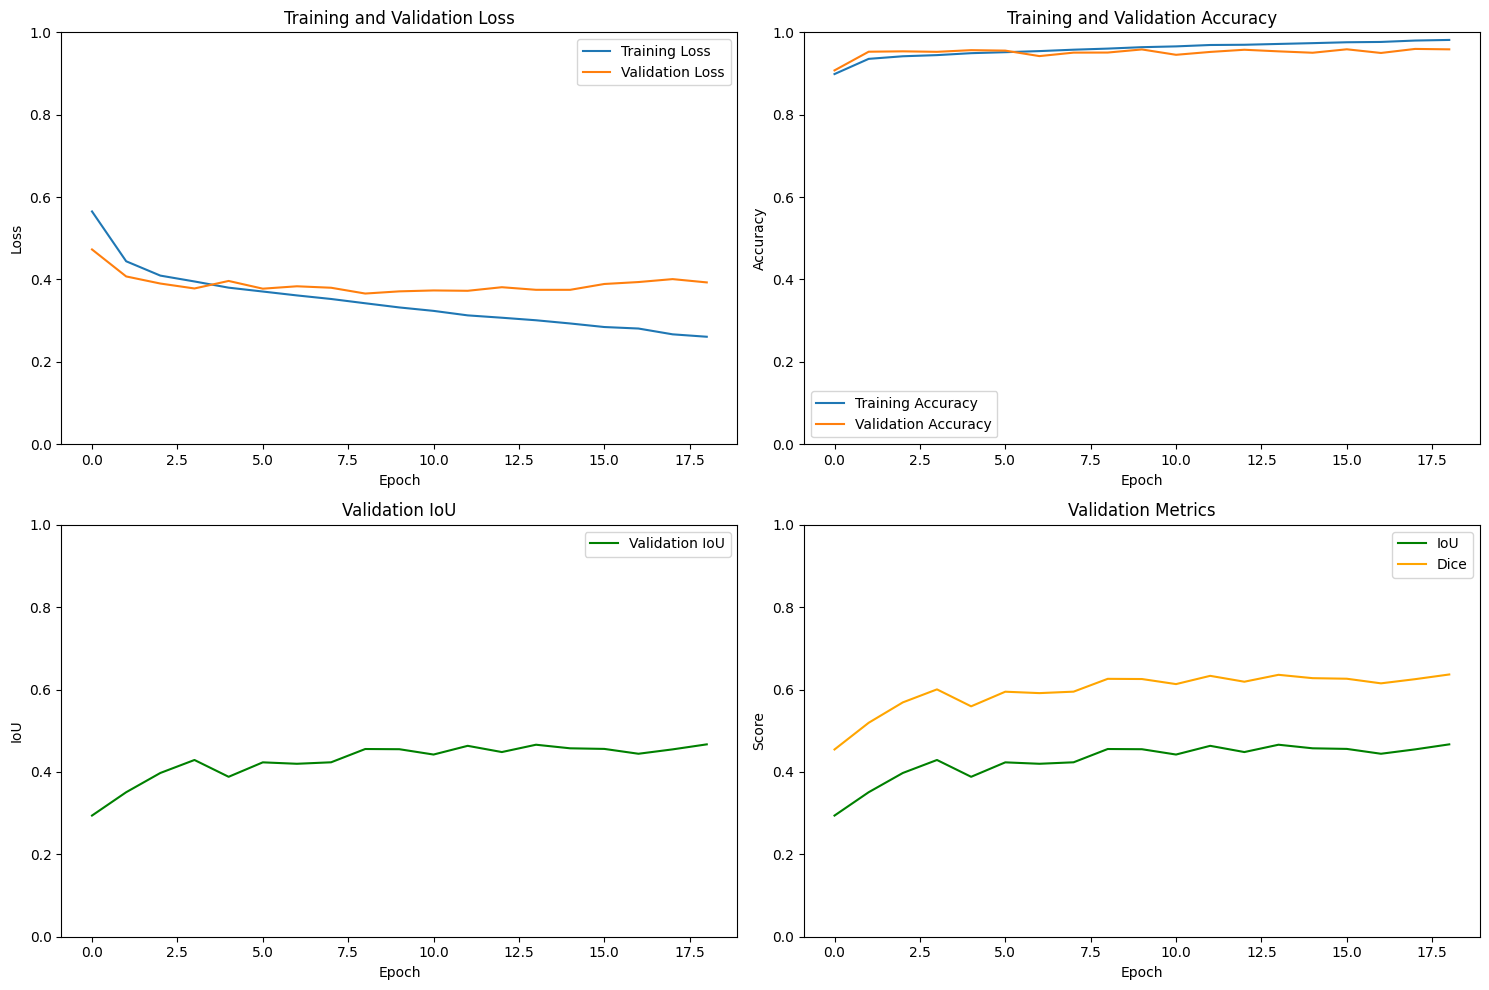

Loading best model for test evaluation...

Evaluating on test set...


Val batch: 100%|██████████| 332/332 [00:10<00:00, 30.99it/s]



SIAMESE U-NET (SE) TEST EVALUATION METRICS
Test set processed with batch_size=1
Loss:            0.364941
IoU:             0.4659
mIoU:            0.7081
Dice Coefficient: 0.6357
Accuracy:        0.9523
Precision:       0.5820
Recall:          0.7002
F1-Score:        0.6357
Confusion matrix (pixel-level):
[[19816669   649572]
 [  387197   904514]]


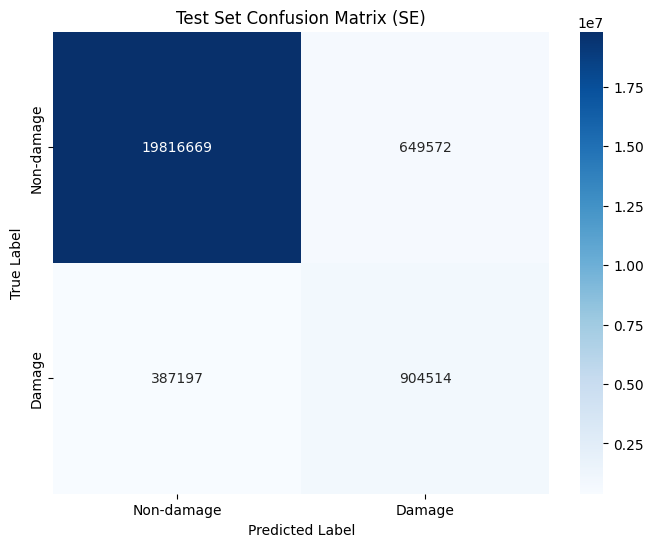

Siamese U-Net (SE) training and evaluation completed!


In [36]:
if __name__ == "__main__":
    main()